In [1]:
import tensorflow as tf # type: ignore
from keras.applications.mobilenet import MobileNet # type: ignore
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Dropout # type: ignore
from keras.models import Model # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
from keras.regularizers import l2 # type: ignore
from keras.preprocessing.image import ImageDataGenerator # type: ignore

In [2]:
base_dir = r"C:\Users\bjaya\Desktop\App\data"
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,  # Add rotation to data augmentation
    brightness_range=[0.2, 1.2],  # Adjust brightness
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flip
    validation_split=0.2
)

In [5]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.1
)

In [6]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training'
)

Found 11504 images belonging to 30 classes.


In [7]:
validation_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 1438 images belonging to 30 classes.


In [8]:
# Create a pre-trained MobileNet model for feature extraction 
base_model = MobileNet(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(30, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Unfreeze the last layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
his = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop], verbose = 1
)

Epoch 1/20


180/180 [==============================] - 339s 2s/step - loss: 10.7006 - accuracy: 0.7039 - val_loss: 9.5572 - val_accuracy: 0.8331 - lr: 1.0000e-04
Epoch 2/20
180/180 [==============================] - 316s 2s/step - loss: 8.3533 - accuracy: 0.9392 - val_loss: 7.5322 - val_accuracy: 0.9485 - lr: 1.0000e-04
Epoch 3/20
180/180 [==============================] - 319s 2s/step - loss: 6.7181 - accuracy: 0.9655 - val_loss: 5.9779 - val_accuracy: 0.9652 - lr: 1.0000e-04
Epoch 4/20
180/180 [==============================] - 314s 2s/step - loss: 5.2890 - accuracy: 0.9783 - val_loss: 4.6714 - val_accuracy: 0.9680 - lr: 1.0000e-04
Epoch 5/20
180/180 [==============================] - 316s 2s/step - loss: 4.0813 - accuracy: 0.9834 - val_loss: 3.6155 - val_accuracy: 0.9604 - lr: 1.0000e-04
Epoch 6/20
180/180 [==============================] - 330s 2s/step - loss: 3.1009 - accuracy: 0.9873 - val_loss: 2.7549 - val_accuracy: 0.9645 - lr: 1.0000e-04
Epoch 7/20
180/180 [=================

In [11]:
model.save("Updated_MobileNet.keras")

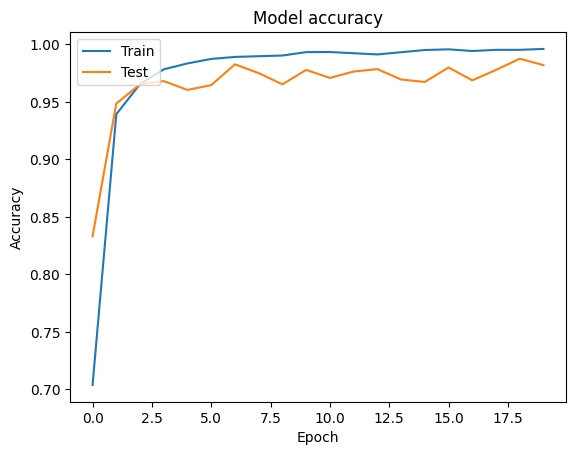

In [12]:
import matplotlib.pyplot as plt # type: ignore
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
import numpy as np # type: ignore
# Evaluate the model
test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

accuracy = np.sum(y_true == y_pred) / len(y_true)
print("Accuracy:", accuracy)

Found 1438 images belonging to 30 classes.
23/23 [==============================] - 21s 904ms/step
Accuracy: 0.9819193324061196


In [14]:
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                         precision    recall  f1-score   support

            Arive-Dantu       1.00      1.00      1.00        50
                 Basale       1.00      1.00      1.00        50
                  Betel       1.00      1.00      1.00        48
          Crape_Jasmine       1.00      1.00      1.00        50
                  Curry       1.00      1.00      1.00        50
              Drumstick       0.82      0.94      0.88        50
              Fenugreek       1.00      0.72      0.84        36
                  Guava       0.94      1.00      0.97        50
               Hibiscus       1.00      1.00      1.00        43
           Indian_Beech       1.00      1.00      1.00        50
         Indian_Mustard       1.00      1.00      1.00        34
              Jackfruit       1.00      1.00      1.00        50
Jamaica_Cherry-Gasagase       1.00      1.00      1.00        50
                  Jamun       1.00      1.00      1.00        39
 

In [15]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  9 26  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 

In [16]:
import pandas as pd # type: ignore
performance_table = pd.DataFrame({
    'Metric': ['Accuracy'],
    'Value': [accuracy]
})
print("Model Performance Table:")
print(performance_table)

Model Performance Table:
     Metric     Value
0  Accuracy  0.981919


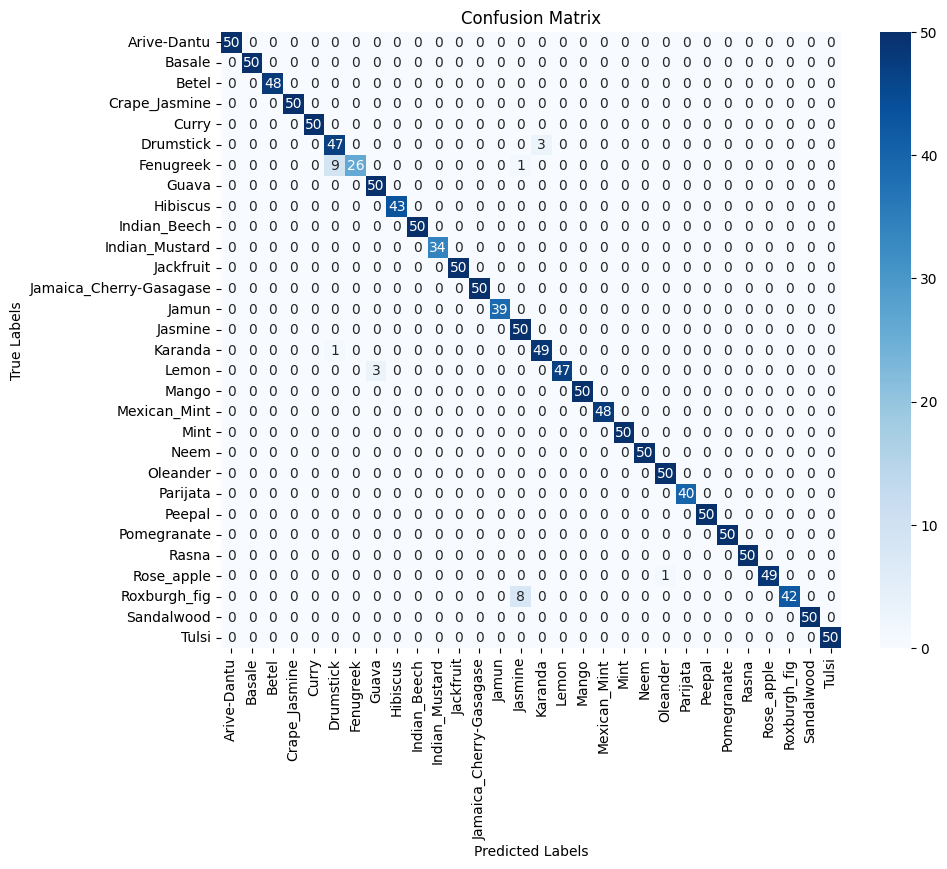

In [21]:
import seaborn as sns # type: ignore
from sklearn.metrics import confusion_matrix # type: ignore

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



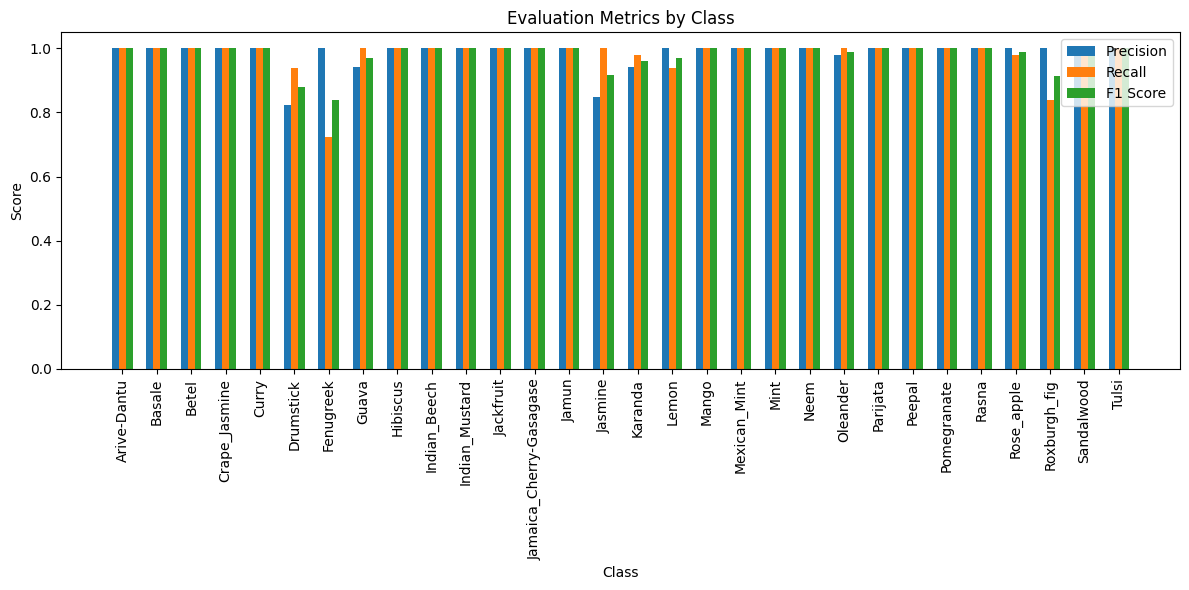

In [22]:
from sklearn.metrics import precision_recall_fscore_support # type: ignore


precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

plt.figure(figsize=(12, 6))
x = np.arange(len(class_names))
bar_width = 0.2
plt.bar(x, precision, width=bar_width, label='Precision')
plt.bar(x + bar_width, recall, width=bar_width, label='Recall')
plt.bar(x + 2*bar_width, f1_score, width=bar_width, label='F1 Score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Evaluation Metrics by Class')
plt.xticks(ticks=x + bar_width, labels=class_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


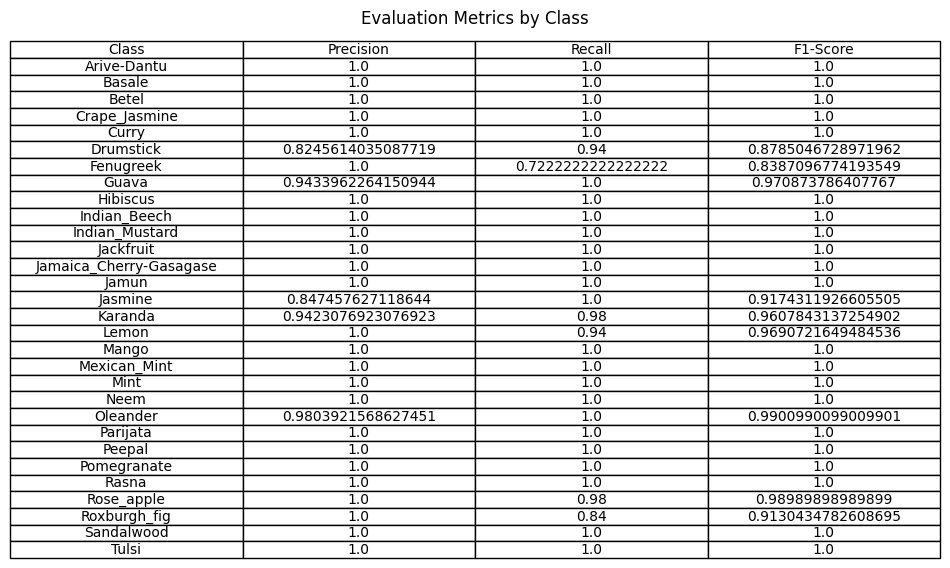

In [23]:
import pandas as pd # type: ignore

metrics_df = pd.DataFrame({'Class': class_names, 'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})

plt.figure(figsize=(12, 6))
plt.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='upper center')
plt.axis('off')
plt.title('Evaluation Metrics by Class')
plt.show()
